In [78]:
#load all neccessary libs
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [79]:
#read  training data set
train = pd.read_csv('train.csv')
meal_info = pd.read_csv('meal_info.csv')
fullfill_info = pd.read_csv('fulfilment_center_info.csv')

In [80]:
#head of these table
train.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [81]:
meal_info.head(5)

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [82]:
meal_info['category'].unique()


array(['Beverages', 'Extras', 'Soup', 'Other Snacks', 'Salad',
       'Rice Bowl', 'Starters', 'Sandwich', 'Pasta', 'Desert', 'Biryani',
       'Pizza', 'Fish', 'Seafood'], dtype=object)

In [83]:
# I see that there is a column 'meal_id' in training set that have various values and in meal info it on ly have 14 groups of food.
# so that i will change all meal_id to this "meal_category". 
# My analysics here is want too see the relationship between meal_Category and timeline in this data set

In [84]:
fullfill_info.head(5)

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [110]:
# merge 2 data train and meal Info
new_train =  train.join(meal_info
             .set_index("meal_id")
             .loc[:, ["category"]],
             on="meal_id")

In [111]:
new_train = new_train.drop(labels=["meal_id","center_id","emailer_for_promotion","homepage_featured"], axis=1)
new_train.head(10)

,id,week,checkout_price,base_price,num_orders,category
0,1379560,1,136.83,152.29,177,Beverages
1,1466964,1,136.83,135.83,270,Beverages
2,1346989,1,134.86,135.86,189,Beverages
3,1338232,1,339.50,437.53,54,Beverages
4,1448490,1,243.50,242.50,40,Beverages
5,1270037,1,251.23,252.23,28,Beverages
6,1191377,1,183.36,184.36,190,Beverages
7,1499955,1,182.36,183.36,391,Beverages
8,1025244,1,193.06,192.06,472,Beverages
9,1054194,1,325.92,384.18,676,Beverages


In [144]:
# now we will group by same week and category for future analysic
y = new_train.groupby(["week","category"]).sum()
#y.to_frame().set_index('category')
y = y.reset_index()

# categoryList = y["category"].values
# categoryList
# y_category = []
# for category in categoryList:
#     print (category)
#     y_category[category] = y.loc[(y["category"]==category)]
#     y_category[category].set_index("week")
#     y_category[category] = y_beverages[["week","num_orders"]]

# y_category["Beverages"].head()

y_beverages = y.loc[y["category"]=="Beverages"]
y_beverages.set_index("week")
#y_beverages = y_beverages["num_orders"]
y_beverages.head()

,week,category,id,checkout_price,base_price,num_orders
0,1,Beverages,1101635531,195333.96,211552.87,322382
12,2,Beverages,1103754775,175066.15,210450.57,381602
24,3,Beverages,1098767669,175142.74,210054.93,332159
36,4,Beverages,1106948439,177237.10,209452.64,345707
48,5,Beverages,1077621389,182163.46,202854.07,280863


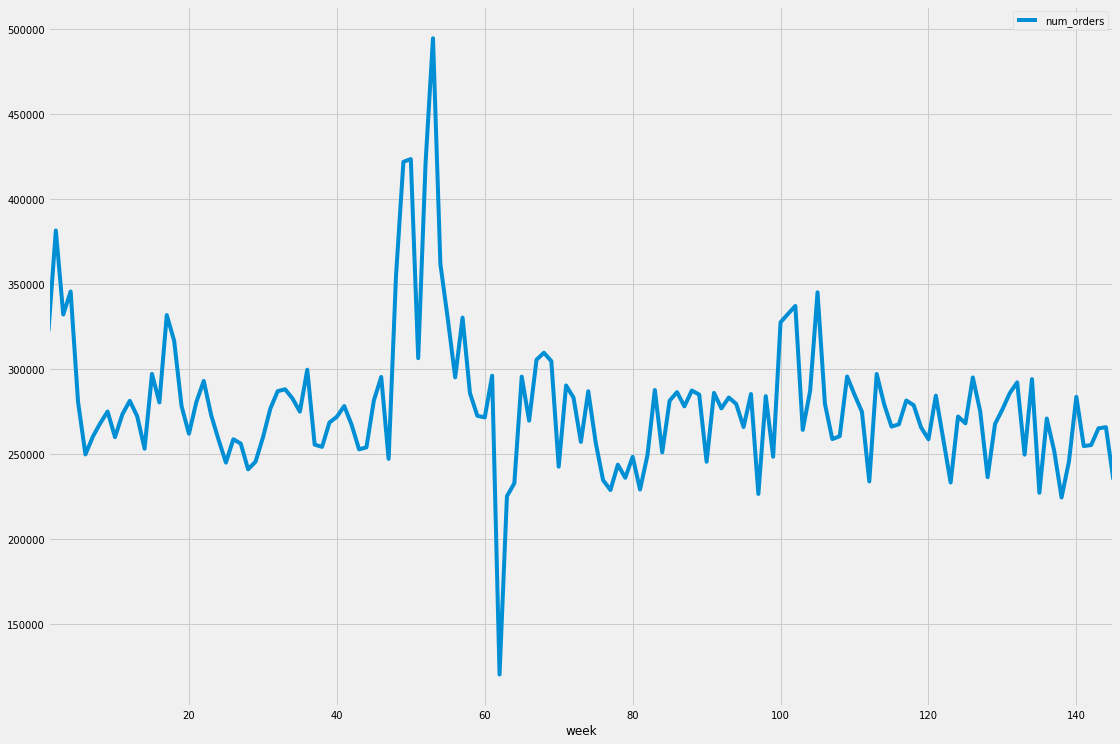

In [145]:
y_beverages.plot(x="week", y="num_orders",figsize=(17,12))

In [146]:
# Using pd.series.rolling to calculate mean and std for item_cnt_day series with window=12
# plot mean and std values
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html
# Your code here
ax = y_beverages.rolling(window=52).mean().plot(y="num_orders")
y_beverages.rolling(window=52).std().plot(y="num_orders", ax=ax)

TypeError: cannot handle this type -> object

In [136]:
# Import seasonal_decompose from statsmodels.tsa.seasonal
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams.update({'figure.figsize': (15,7), 'font.size': 10})
# Plot decompose diagram using seasonal_decompose

res = seasonal_decompose(y_beverages["num_orders"] ,freq=52, model="additive")
fig = res.plot();


KeyError: 'num_orders'

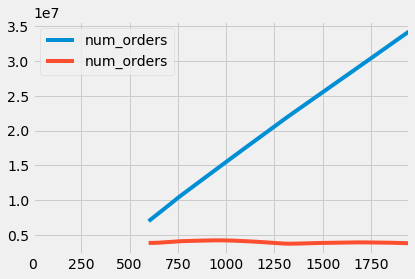